In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

In [2]:
import logging

import polars as pl
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

from playground.logs import setup_logging

2023-03-11 10:05:59.982058: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-11 10:06:00.712130: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-11 10:06:00.712172: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-11 10:06:02.815243: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [3]:
setup_logging()
logger = logging.getLogger(__name__)

# Load data

In [4]:
TRAIN_FILE_PATH = Path.cwd() / "train.csv"
assert TRAIN_FILE_PATH.exists()
assert TRAIN_FILE_PATH.is_file()

In [17]:
train_df = pl.read_csv(TRAIN_FILE_PATH).with_columns([
    pl.lit(0.0).alias("is_old"),
])
train_df.shape

(5407, 11)

In [6]:
TEST_FILE_PATH = Path.cwd() / "test.csv"
assert TEST_FILE_PATH.exists()
assert TEST_FILE_PATH.is_file()

In [18]:
test_df = pl.read_csv(TEST_FILE_PATH).with_columns([
    pl.lit(0.0).alias("is_old"),
])
test_df.shape

(3605, 10)

In [10]:
OLD_TRAIN_FILE_PATH = Path.cwd() / "old.csv"
assert OLD_TRAIN_FILE_PATH.exists()
assert OLD_TRAIN_FILE_PATH.is_file()

In [40]:
old_df = pl.read_csv(OLD_TRAIN_FILE_PATH).with_columns([
    pl.lit(1.0).alias("is_old"),
    pl.lit(-1, dtype=pl.Int64).alias("id"),
])
old_df.shape

(1030, 11)

# Feature transformation

In [41]:
ID_COLUMN = 'id'
FEATURE_COLUMNS = [
    "CementComponent",
    "BlastFurnaceSlag",
    "FlyAshComponent",
    "WaterComponent",
    "SuperplasticizerComponent",
    "CoarseAggregateComponent",
    "FineAggregateComponent",
    "AgeInDays",
]
OLD_COLUMN = 'is_old'
TARGET_COLUMN = "Strength"


In [42]:
means = dict(
    zip(
        FEATURE_COLUMNS,
        train_df.select([pl.col(col).mean() for col in FEATURE_COLUMNS]).row(0),
    )
)
means


{'CementComponent': 299.16818938413167,
 'BlastFurnaceSlag': 58.610578879230644,
 'FlyAshComponent': 31.87279452561494,
 'WaterComponent': 185.0762345108192,
 'SuperplasticizerComponent': 4.10844090993157,
 'CoarseAggregateComponent': 992.0007175883115,
 'FineAggregateComponent': 771.2199741076375,
 'AgeInDays': 51.75161827260958}

In [43]:
stds = dict(
    zip(
        FEATURE_COLUMNS,
        train_df.select([pl.col(col).std() for col in FEATURE_COLUMNS]).row(0),
    )
)
stds

{'CementComponent': 105.53768168118059,
 'BlastFurnaceSlag': 83.41780074487346,
 'FlyAshComponent': 54.60500297587532,
 'WaterComponent': 18.517583489378303,
 'SuperplasticizerComponent': 5.692296206281762,
 'CoarseAggregateComponent': 77.14801045239005,
 'FineAggregateComponent': 78.72525270217871,
 'AgeInDays': 70.00697526599377}

In [44]:
def transform(df: pl.DataFrame) -> pl.DataFrame:
    return df.with_columns(
        [(pl.col(col) - means[col]) / stds[col] for col in FEATURE_COLUMNS]
        + [pl.col(OLD_COLUMN)]
    )


In [45]:
train_transformed_df = transform(train_df)
train_transformed_df

id,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength,is_old
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0,2.139822,-0.702615,-0.583697,0.049886,-0.721755,1.72395,-2.009774,-0.696382,10.38,0.0
1,-1.479739,1.323332,2.03511,0.319899,0.683654,-0.324062,-1.628702,-0.339275,23.52,0.0
2,-0.096347,0.912148,-0.583697,0.033685,-0.721755,1.075845,0.305874,-0.339275,36.96,0.0
3,0.045783,0.208462,-0.583697,2.318,-0.721755,-0.777735,-1.285737,4.474531,39.05,0.0
4,-1.347085,2.126518,-0.583697,0.373902,-0.721755,-0.733664,0.12677,0.546351,74.19,0.0
5,0.481646,-0.702615,-0.583697,0.967932,-0.721755,0.816603,0.048015,-0.639245,37.43,0.0
6,-1.548908,1.736913,-0.583697,0.033685,-0.721755,1.091399,-0.151412,-0.339275,35.1,0.0
7,0.315829,1.005654,-0.583697,2.318,-0.721755,-0.777735,-2.25112,-0.339275,45.94,0.0
8,0.216338,-0.702615,-0.583697,0.967932,-0.721755,-0.233327,0.365576,1.831937,42.14,0.0


In [46]:
test_transformed_df = transform(test_df)
test_transformed_df

id,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,is_old
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64
5407,-1.26086,0.201269,2.416028,-0.608947,0.086355,0.197015,-0.312733,0.060685,0.0
5408,0.045783,-0.702615,-0.583697,0.265897,-0.721755,0.077763,0.378278,-0.639245,0.0
5409,-0.702765,-0.702615,-0.583697,-0.004117,-0.721755,1.568404,0.784755,-0.339275,0.0
5410,-0.452617,-0.702615,1.582771,0.184893,0.402572,0.471811,-0.171736,0.689194,0.0
5411,-1.470263,-0.522797,2.987404,-0.490141,0.332302,0.375892,-0.790343,-0.339275,0.0
5412,-0.353127,0.628036,1.01872,0.562912,0.314734,-2.066168,0.243632,-0.339275,0.0
5413,-1.413412,-0.702615,-0.583697,-0.598147,-0.282565,0.998072,-1.209523,-0.339275,0.0
5414,-0.249846,1.477975,-0.583697,0.033685,-0.721755,0.264417,-0.723021,-0.639245,0.0
5415,0.186017,1.844803,-0.583697,-1.586397,0.244464,-1.813407,1.117558,-0.339275,0.0


In [47]:
old_transformed_df = transform(old_df)
old_transformed_df

CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength,is_old,id
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64
2.281951,-0.702615,-0.583697,-1.24618,-0.282565,0.622171,-1.209523,-0.339275,79.99,1.0,-1
2.281951,-0.702615,-0.583697,-1.24618,-0.282565,0.816603,-1.209523,-0.339275,61.89,1.0,-1
0.315829,1.005654,-0.583697,2.318,-0.721755,-0.777735,-2.25112,3.117523,40.27,1.0,-1
0.315829,1.005654,-0.583697,2.318,-0.721755,-0.777735,-2.25112,4.474531,41.05,1.0,-1
-0.952913,0.884576,-0.583697,0.373902,-0.721755,-0.176294,0.689487,4.40311,44.3,1.0,-1
-0.314278,0.664,-0.583697,2.318,-0.721755,-0.777735,-1.285737,0.546351,47.03,1.0,-1
0.765905,0.436231,-0.583697,2.318,-0.721755,-0.777735,-2.25112,4.474531,43.7,1.0,-1
0.765905,0.436231,-0.583697,2.318,-0.721755,-0.777735,-2.25112,-0.339275,36.45,1.0,-1
-0.314278,0.664,-0.583697,2.318,-0.721755,-0.777735,-1.285737,-0.339275,45.85,1.0,-1


In [49]:
train_ids, rest_ids = train_test_split(train_transformed_df[ID_COLUMN], test_size=0.2, random_state=42)

In [50]:
val_ids, eval_ids = train_test_split(rest_ids, test_size=0.5, random_state=42)

In [51]:
logger.debug("Train samples %s, validation samples %s, evaluation samples %s", len(train_ids), len(val_ids), len(eval_ids))

[2023-03-11 10:13:29,710][   DEBUG][__main__] Train samples 4325, validation samples 541, evaluation samples 541


In [52]:
train_split_df = train_transformed_df.filter(pl.col(ID_COLUMN).is_in(train_ids))
val_split_df = train_transformed_df.filter(pl.col(ID_COLUMN).is_in(val_ids))
eval_split_df = train_transformed_df.filter(pl.col(ID_COLUMN).is_in(eval_ids))

In [53]:
logger.debug("Train samples %s, validation samples %s, evaluation samples %s", len(train_split_df), len(val_split_df), len(eval_split_df))

[2023-03-11 10:13:35,220][   DEBUG][__main__] Train samples 4325, validation samples 541, evaluation samples 541


In [55]:
train_and_old_split_df = pl.concat([train_split_df, old_transformed_df.select(train_split_df.columns)])
train_and_old_split_df.shape

(5355, 11)

In [56]:
def df_to_dataset(df: pl.DataFrame) -> tf.data.Dataset:
    return tf.data.Dataset.from_tensor_slices({
        col: df[col].to_numpy()
        for col in df.columns
    })

In [57]:
def pop_target(tensors: dict[str, tf.Tensor]) -> tuple[dict[str, tf.Tensor], tf.Tensor]:
    target = tensors.pop(TARGET_COLUMN)
    return tensors, target

In [62]:
batch_size = 32
train_ds = df_to_dataset(train_and_old_split_df).shuffle(len(train_and_old_split_df), reshuffle_each_iteration=True).batch(batch_size).map(pop_target)
val_ds = df_to_dataset(val_split_df).batch(batch_size).map(pop_target)
eval_ds = df_to_dataset(eval_split_df).batch(batch_size).map(pop_target)

In [63]:
for inputs, target in train_ds.take(1):
    logger.debug("Inputs: %s", inputs)
    logger.debug("Target: %s", target)

[2023-03-11 10:16:12,865][   DEBUG][__main__] Inputs: {'id': <tf.Tensor: shape=(32,), dtype=int64, numpy=
array([1750, 2961,   -1,  110, 2726,   -1, 4280, 1251, 3990, 4285,   -1,
       5327, 4984, 3757,  827, 2424,   -1,   -1,   -1, 4093, 1908, 3697,
       3160, 4830, 5222,   -1, 4548, 3783, 2711,   -1, 2999,  563])>, 'CementComponent': <tf.Tensor: shape=(32,), dtype=float64, numpy=
array([ 0.88908349, -1.27128233,  0.47217079, -0.44408962,  2.1398216 ,
        0.60103472, -0.90648371, -1.73557147,  0.72800358,  0.216338  ,
       -0.44408962,  0.60103472, -0.57958625, -0.59853683,  0.47217079,
        0.76590474,  0.70905301, -0.45261738, -0.31427817, -1.2343287 ,
        0.37931296, -0.44219457,  0.83223176, -0.0394948 , -1.27128233,
       -1.2210633 , -0.08308113, -1.38498579,  0.48164608,  2.11139573,
        2.28195093, -0.31427817])>, 'BlastFurnaceSlag': <tf.Tensor: shape=(32,), dtype=float64, numpy=
array([-0.70261477, -0.70261477, -0.70261477, -0.70261477, -0.70261477,
     

In [65]:
id_input = tf.keras.Input(shape=(), name=ID_COLUMN, dtype=tf.int64)
feature_inputs = {
    col: tf.keras.Input(shape=(), name=col, dtype=tf.float32)
    for col in FEATURE_COLUMNS
}
old_input = tf.keras.Input(shape=(), name=OLD_COLUMN, dtype=tf.float32)

In [76]:
concatenated_features = tf.stack([*feature_inputs.values(), old_input], axis=1)
seq = tf.keras.Sequential([
    tf.keras.layers.Dense(64),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(32),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(1),
])
output = seq(concatenated_features)

In [77]:
model = tf.keras.Model(inputs={**feature_inputs, OLD_COLUMN: old_input}, outputs=output)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()],
)

In [78]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    verbose=1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            patience=10, restore_best_weights=True, verbose=1
        ),
    ],
)


Epoch 1/100
168/168 [==============================] - 3s 5ms/step - loss: 1442.3912 - mean_absolute_error: 34.5418 - root_mean_squared_error: 37.9788 - val_loss: 1311.1172 - val_mean_absolute_error: 32.7809 - val_root_mean_squared_error: 36.2094
Epoch 2/100
168/168 [==============================] - 1s 3ms/step - loss: 1122.2035 - mean_absolute_error: 30.2420 - root_mean_squared_error: 33.4993 - val_loss: 1054.7739 - val_mean_absolute_error: 29.3470 - val_root_mean_squared_error: 32.4773
Epoch 3/100
168/168 [==============================] - 1s 3ms/step - loss: 749.0224 - mean_absolute_error: 24.0045 - root_mean_squared_error: 27.3683 - val_loss: 571.8798 - val_mean_absolute_error: 20.5713 - val_root_mean_squared_error: 23.9140
Epoch 4/100
168/168 [==============================] - 1s 4ms/step - loss: 432.5745 - mean_absolute_error: 17.0250 - root_mean_squared_error: 20.7984 - val_loss: 252.3605 - val_mean_absolute_error: 12.4057 - val_root_mean_squared_error: 15.8859
Epoch 5/100
168/

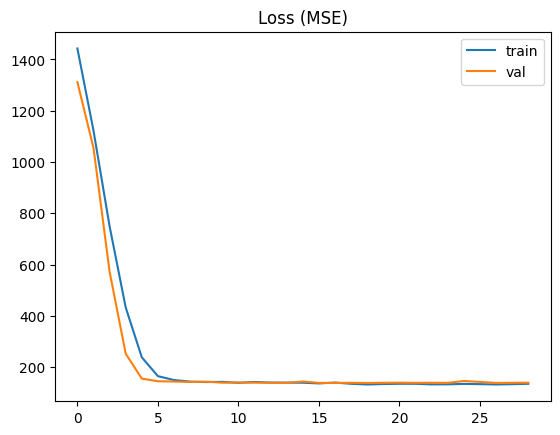

In [79]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss (MSE)')
plt.legend()

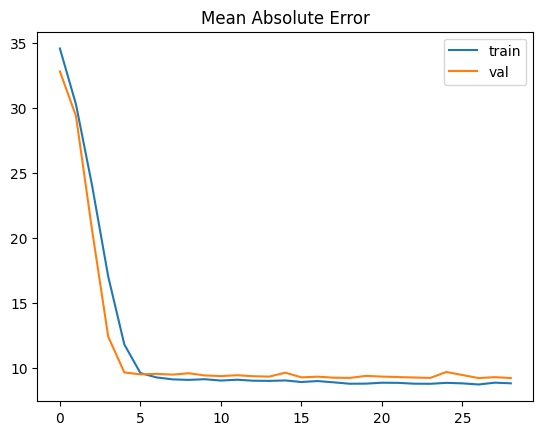

In [80]:
plt.plot(history.history['mean_absolute_error'], label='train')
plt.plot(history.history['val_mean_absolute_error'], label='val')
plt.title('Mean Absolute Error')
plt.legend()

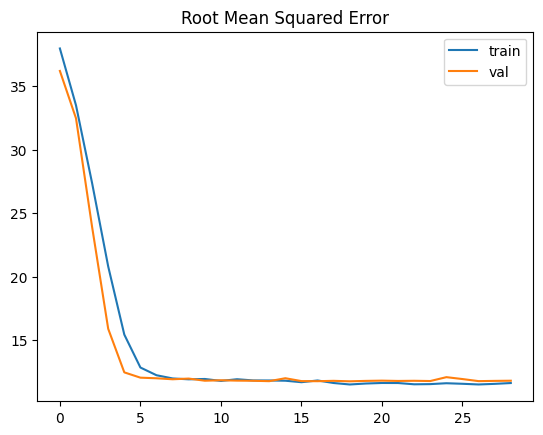

In [81]:
plt.plot(history.history['root_mean_squared_error'], label='train')
plt.plot(history.history['val_root_mean_squared_error'], label='val')
plt.title('Root Mean Squared Error')
plt.legend()

In [82]:
eval_mse, eval_mae, eval_rmse = model.evaluate(eval_ds)
logger.info("Evaluation MSE: %s, MAE: %s, RMSE: %s", eval_mse, eval_mae, eval_rmse)

17/17 [==============================] - 0s 3ms/step - loss: 149.1778 - mean_absolute_error: 9.4737 - root_mean_squared_error: 12.2138


[2023-03-11 10:19:32,469][    INFO][__main__] Evaluation MSE: 149.17782592773438, MAE: 9.473679542541504, RMSE: 12.213837623596191


In [84]:
wrapper_model = tf.keras.Model(inputs={
    ID_COLUMN: id_input,
    OLD_COLUMN: old_input,
    **feature_inputs,
}, outputs={
    ID_COLUMN: id_input,
    TARGET_COLUMN: tf.squeeze(model({**feature_inputs, OLD_COLUMN: old_input}, training=False), axis=1),
})

In [85]:
test_ds = df_to_dataset(test_transformed_df).batch(batch_size)

In [86]:
predictions = wrapper_model.predict(test_ds)

113/113 [==============================] - 1s 2ms/step


In [87]:
{k: v.shape for k, v in predictions.items()}

{'id': (3605,), 'Strength': (3605,)}

In [88]:
pl.DataFrame(predictions).write_csv(Path.cwd() / 'submission.csv')